### Preparations
#### Load data and functions

First you have to install some things you need - run the block below

In [ ]:
# !pip install -r requirements.txt

If that doesn't work, run the block below - but only if the above doesn't work

In [ ]:
# %pip install -r requirements.txt

In [1]:
from functions import read_data, plot_votes_vs_x, bert_scores_en

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

In [3]:
(ideas, comments, ideator) = read_data()

#### Add relevant columns - preprocessing

In [4]:
# Add column n_comments with the number of comments to each idea
ideas["n_comments"] = 0
for ID in ideas["Submission.ID"]:
    ideas.loc[ideas["Submission.ID"] == ID, "n_comments"] = len(comments[comments["Submission.ID"] == ID])    

In [5]:
# Add number of words in description of ideas
ideas["n_words"] = [len(idea.split()) for idea in ideas["Body"]]

In [6]:
# Add department of person posting idea
ideas["department"] = [ideator.loc[ideator["user_id"]==i, "department"].values[0] for i in ideas["user_id"]]
ideas["department"] = ["IT" if dep in ["IT", "it"] else "HR" if dep in ["HR", "hr"] else dep for dep in ideas["department"]]

##### Sentiment scores

We calculate the sentiment scores using a pretrained model, meaning someone else has already made it. It gives each idea a label; either it is positive, neutral or negative. I convert these labels to numbers, with positive = 1, neutral = 0 and negative = -1. Therefore, if the mean sentiment score of four ideas is 0, it may be because there are two positive and two negative comments (2*1+2*-1 = 0), or because they are all neutral (4*0=0).

In [7]:
# Extract sentiment of each of the comments
sentiment = bert_scores_en(comments, "Comment")

In [8]:
# Calculate mean sentiment of comments for each idea
mean_sentiment = sentiment.groupby("Submission.ID", as_index=False)["polarity_score"].mean()

# Adding to ideas DataFrame
pol_tuples = list(zip(mean_sentiment["Submission.ID"], mean_sentiment["polarity_score"]))
ideas["mean_comment_sentiment"] = 0
for tup in pol_tuples:
    idea_id, mean_score = tup
    ideas.loc[ideas["Submission.ID"]==idea_id, "mean_comment_sentiment"] = mean_score

In [34]:
# Getting an example of each sentiment category
print(f'Example of a positive comment: \n{comments[comments["polarity"] == "POS"]["Comment"][15]}\n')
print(f'Example of a negative comment: \n{comments[comments["polarity"] == "NEG"]["Comment"][18]}\n')
print(f'Example of a netural comment: \n{comments[comments["polarity"] == "NEU"]["Comment"][20]}\n')
        

Example of a positive comment: 
Nice idea Graham, Turn the issue into FUN! Could be that every box has a graphic where the Minifigures are trying to pull, push, cut, rip, use a jack hammer etc. to open the box, just where the graphic for "PUSH" here to open.

Example of a negative comment: 
Reminds me of my childhood when i tried to build a mouse-trap out of LEGO Technic elements. Although it actually saw the light of day my mother did not allow me to put it into action. I guess she didn't know how to clean the bricks properly in case I was successful.

Example of a netural comment: 
This is not only true of childhood but I have the same feelings now when I build! You can lose yourself without any sense of time and get drawn into the desire to build, create and finish :)



The dataframe now looks like this (run block below). Notice the column on the far right with sentiment

In [35]:
ideas.head()

,user_id,Submission.ID,Topic.Alias,Title,Body,idea type,tags,Publish.Date,Number.of.Votes,Status(selectedbyexpert),prior_experience(idea generation),n_comments,n_words,department,mean_comment_sentiment
0,8,4,core-experience,Make it easier to open the box,Often I see a LEGO box get torn open because i...,Current experience journey,na,2012-12-20 05:05:21,25,1,0,17,37,innovation,0.294118
1,8,91,your-ideas,Reconnect with childhood,When taking visitors through the Idea House I ...,product ideas-sets,"retro, classic",2013-01-25 16:58:21,7,0,0,7,74,innovation,0.571429
2,16,205,core-experience,LEGO City Counstryside,Hi :) During the christmas holiday I was play...,New ways to build and play,NaN,2013-01-07 07:37:46,2,0,0,2,153,design,-0.500000
3,17,51,your-ideas,Garbage Cans in Billund Parking House,The parking house in Billund provides great pa...,Facilities > Optimization,"garbage, trash, parking, implemented, environm...",2012-12-20 14:15:49,15,0,0,10,101,operations,0.500000
4,17,65,your-ideas,Save Energy,We can easily help saving energy by switching ...,Sustainability > Strategy,"planet promise, energy efficiency",2012-12-20 21:01:05,19,0,0,9,76,operations,0.555556


## Most popular by votes/comment sentiment

#### Top 10 ideas with most votes

In [21]:
top_votes = ideas.sort_values("Number.of.Votes", ascending=False).head(10)

The top 10 ideas by votes cannot fit in a single out-put print. It is therefore split so that the five most popluar ideas are displayed when running the next block, and the 5-10 most popular ideas are displayed when running the block following that. 

In [30]:
# Top five most popular
i = 1
for _, row in top_votes.iterrows():
    # print(i, row)
    print(f'The {i}. most popular idea by votes has {row["Number.of.Votes"]} votes, and the idea is:\n{row["Body"]}\n')
    i += 1
    if i == 6:
        break

The 1. most popular idea by votes has 29 votes, and the idea is:
I think it would make the gifts of the Advent Calendar truely amazing, if after the 24th there would be a building instruction where using the the bricks of 24 small gifts you could make one big thing. F.ex for Star Wars that you could create a bigger spaceship with the bricks. First,  it would make  day 24 truely special. Second,  it would show to the kids that bricks can be used in different ways,  and encourage them to be creative (and not just assemble sets once)."

The 2. most popular idea by votes has 28 votes, and the idea is:
Consumer Services handles many contacts from disappointed fans who have purchased â€œfactory sealedâ€ packages that are missing all the minifigures. These consumers have usually bought the set at a non LBR retail store.   There is nothing worse than opening up your new Star Wars or Ninjago set and finding that the minifigures are all gone! The current tape that we use to seal the boxes can e

In [31]:
# Top five-ten most popular
i = 1
for _, row in top_votes.iterrows():
    if i < 6:
        i += 1
        continue
    print(f'The {i}. most popular idea by votes has {row["Number.of.Votes"]} votes, and the idea is:\n{row["Body"]}\n')
    i += 1
    

The 6. most popular idea by votes has 20 votes, and the idea is:
I have for some time been wondering. What actually happens with the spare food from the LEGO canteens? When I was at a seminar at a large-sized company they had a great arrangement, where the employees could buy a small dinner package they could bring home. This would be a great service and a way to reduce food waste.

The 7. most popular idea by votes has 20 votes, and the idea is:
An element that really could give many new building ways and posibilities would be plates with knobs on both sides. Like a 2x4 plate without tubeside,  but instead knobs equal to the other side.. Same we could do woth 2x2,  1x2 and so on…This would really give news ways of building,  and one don't need to build tube against tube side,  like the B-wing... I really dont like the cracks of air between the plates  and here this would be an awesome solution..Update: I uploaded a pictures of an element  we use internaly here in Verification  for set

#### Top 10 ideas with most positive comments

In [33]:
top_comment_sentiment = ideas.sort_values("mean_comment_sentiment", ascending=False).head(10)

In [39]:
# Top five most popular
i = 1
for _, row in top_comment_sentiment.iterrows():
    # print(i, row)
    print(f'''The {i}. most popular idea by comment sentiment has a mean comment sentiment score of {row["mean_comment_sentiment"]}, and the idea is:
{row["Body"]}.
The mean score is calculated based on {row["n_comments"]} comments\n''')
    i += 1
    if i == 6:
        break

The 1. most popular idea by comment sentiment has a mean comment sentiment score of 1.0, and the idea is:
I don't really know if this is the right forum to express my feelings regarding this years Lego Christmas set. But I would like to thank all of you very much for this amazing set, who has been incvolved in the design, manufacturing and delivering these sets. I have been working for Lego since december of 2008., when the Lego took over the Flextronics factory in Nyiregyhaza, but I can tell you that this box was the most exciting one since that takeover. Maybe it was beacuse this box contained a much more detailed Lego model, and of course much more pieces, than the previous ones. So keep up the good work guys,  I hope this years Christmas presents will be at least this exciting and good,  like last years.".
The mean score is calculated based on 1 comments

The 2. most popular idea by comment sentiment has a mean comment sentiment score of 1.0, and the idea is:
I think that it would 

In [40]:
# Top five-ten most popular
i = 1
for _, row in top_comment_sentiment.iterrows():
    if i < 6:
        i += 1
        continue
    print(f'''The {i}. most popular idea by comment sentiment has a mean comment sentiment score of {row["mean_comment_sentiment"]}, and the idea is:
{row["Body"]}.
The mean score is calculated based on {row["n_comments"]} comments\n''')
    i += 1

The 6. most popular idea by comment sentiment has a mean comment sentiment score of 1.0, and the idea is:
I was thinking that LEGO Friends is such a hughe success for the same reasons the EA Game's SIMs has been a success - the building and detailing of a real life world where you can be who you want and live like you want. Maybe we should consider collaborating with EA Games and making a Friends-Sims-edition - maybe just the virtual version (I mean as a computer game) - but maybe also with the possibility of designing your own LEGO Friends figure and house and have this specially made and sent to you?  How cool would that be!?".
The mean score is calculated based on 2 comments

The 7. most popular idea by comment sentiment has a mean comment sentiment score of 1.0, and the idea is:
It's Christmas and a child is visiting somewhere and they unwrap a LEGO set.  In my family, the child always begs to open it right away.  And their parents always say, "no, wait until you get it home."  Of 

Notice that most of the comments with highest mean sentiment score is based on 1-2 comments, and that they all have a score of 1 (meaning that all comments were classified as positive). This makes the results less useful, as a single positive comment can thus make an idea one of the ten most popular based on comment sentiment

## Regression models

### Model 1

In [11]:
# Prepare model
model_1 = linear_model.LinearRegression()
le = LabelEncoder()

In [12]:
# Prepare data
X1 = ideas[["mean_comment_sentiment", "n_words", "n_comments"]]
X1["idea type"] = le.fit_transform(ideas["idea type"]) # Convert the names to numbers which is better for the model
y1 = ideas["Number.of.Votes"]

/home/stine/.virtualenvs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Fit the model
model_1.fit(X1, y1)
coefficients_1 = model_1.coef_

In [14]:
print(f'''Coefficients for the four variables are \nMean comment sentiment: {round(coefficients_1[0],2)}, 
Length of description (number of words): {round(coefficients_1[1],2)}, 
Number of comments: {round(coefficients_1[2],2)} and 
Idea type: {round(coefficients_1[3],2)}''')

Coefficients for the four variables are 
Mean comment sentiment: 0.83, 
Length of description (number of words): 0.0, 
Number of comments: 1.22 and 
Idea type: -0.02


The coefficients indicate that number of comments and mean sentiment of comments are most important for predicting the number of votes for a given idea

### Model 2

In [15]:
# Prepare model
model_2 = linear_model.LinearRegression()
le = LabelEncoder()

In [16]:
# Prepare data
X2 = ideas[["Number.of.Votes", "n_words", "n_comments"]]
X2["idea type"] = le.fit_transform(ideas["idea type"])
y2 = ideas["mean_comment_sentiment"]

/home/stine/.virtualenvs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Fit the model
model_2.fit(X2, y2)
coefficients_2 = model_2.coef_

In [18]:
print(f'''Coefficients for the four variables are \nMean comment sentiment: {round(coefficients_2[0],2)}, 
Length of description (number of words): {round(coefficients_2[1],2)}, 
Number of comments: {round(coefficients_2[2],2)} and 
Idea type: {round(coefficients_2[3],2)}''')

Coefficients for the four variables are 
Mean comment sentiment: 0.01, 
Length of description (number of words): 0.0, 
Number of comments: -0.01 and 
Idea type: 0.01


Model 2 seems to be much weaker. It is note very easy to predict the comment sentiment based on the remaining variables

## Plotting

First plot: Idea type vs number of votes. There is a clear tendency in the number of ideas produced under each idea type, but no clear tendency in whether the ideas get many votes.

/home/stine/minnov/minnov/group_1/functions.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation = rotation, ha="right", fontsize=12)


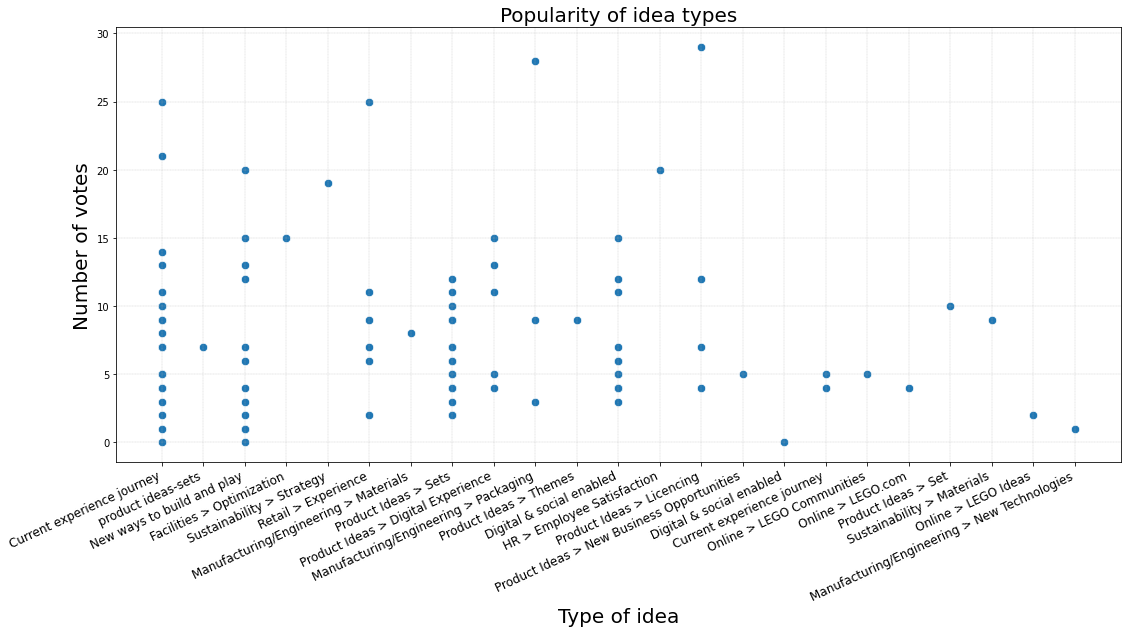

In [ ]:
x_labels = [idea_type for idea_type in ideas["idea type"].unique() if not isinstance(idea_type, float)]
plot_votes_vs_x(df=ideas, 
                x="idea type", 
                x_label="Type of idea", 
                title="Popularity of idea types", 
                x_tick_labels=x_labels, 
                rotation=25);

Second plot: Number of comments vs number of votes. There seems to be a generally positive trend. It seems that the more comments an idea gets, the more likely it is to also get many votes. However, the distribution is skewed to the left, meaning that many more ideas had a low number of comments and only a few ideas had a lot of comments. 

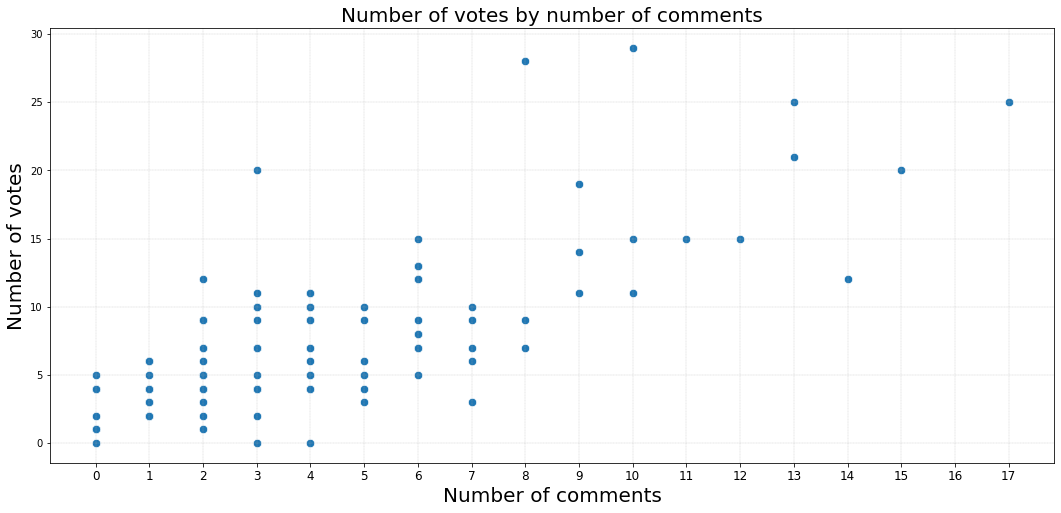

In [ ]:
x_ticks = range(max(ideas["n_comments"]+1))
p2 = plot_votes_vs_x(df=ideas, 
                x="n_comments", 
                x_label="Number of comments", 
                title="Number of votes by number of comments", 
                x_tick_labels=x_ticks);

Adding regression line to the plot above to see the tendency. 

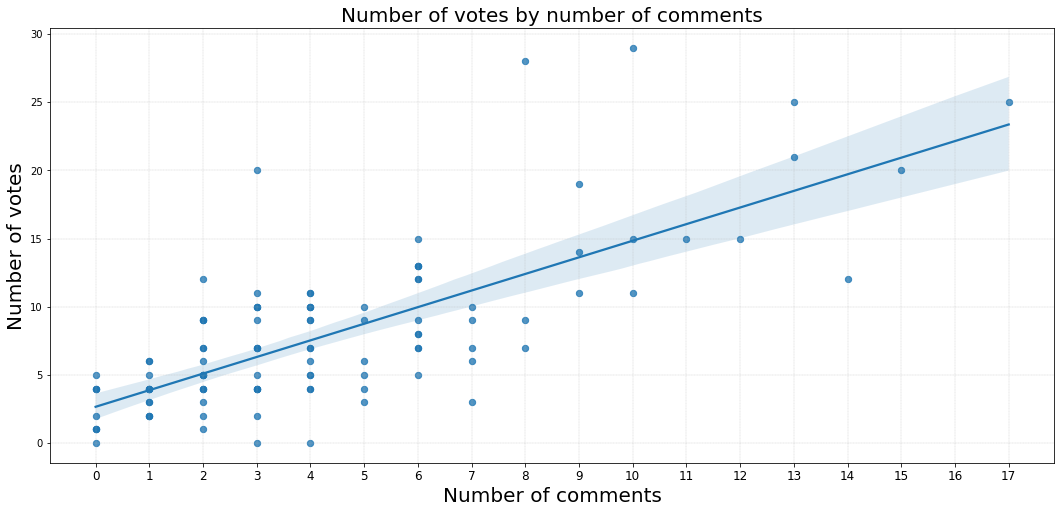

In [ ]:
plot_votes_vs_x(df=ideas, 
                x="n_comments", 
                x_label="Number of comments", 
                title="Number of votes by number of comments", 
                x_tick_labels=x_ticks,
                add_reg_line=True);

Third plot: Length of description (i.e., number of words used) vs number of votes. No clear pattern can be found.

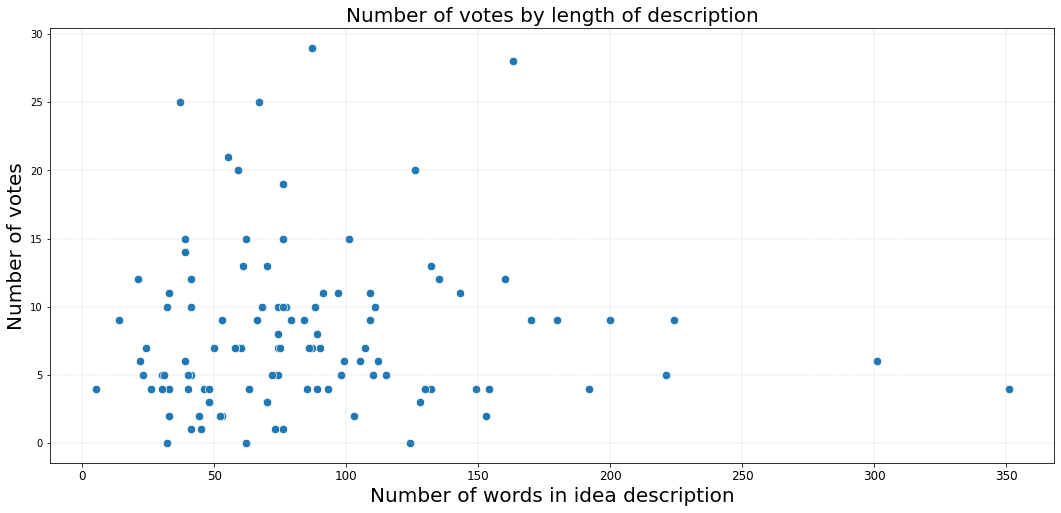

In [ ]:
plot_votes_vs_x(df=ideas, 
                x="n_words", 
                x_label="Number of words in idea description",
                title="Number of votes by length of description");

Fourth plot: Number of comments vs length of description. No pattern.

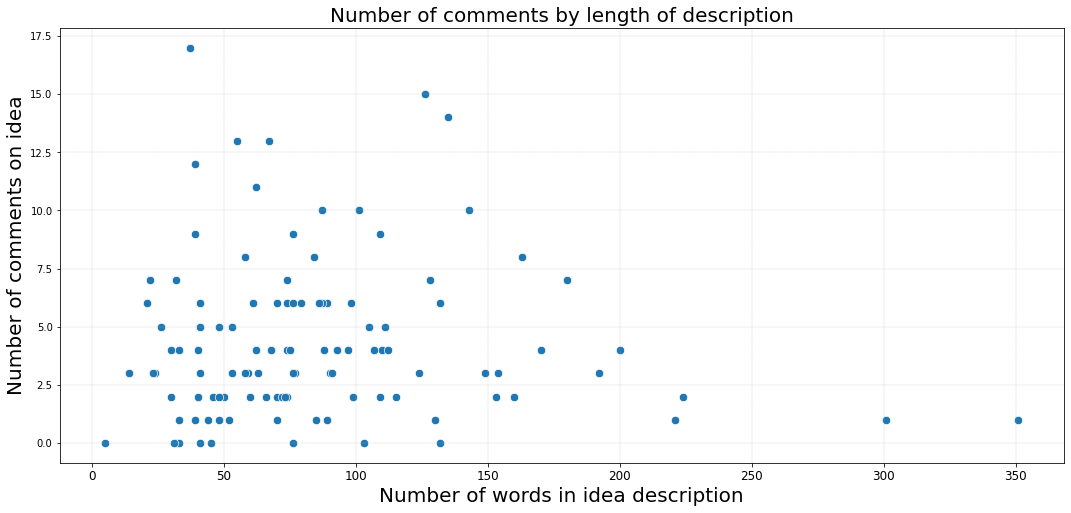

In [ ]:
plot_votes_vs_x(df=ideas,
                x="n_words",
                x_label="Number of words in idea description",
                y="n_comments",
                y_label="Number of comments on idea",
                title="Number of comments by length of description");

Mean comment sentiment vs number of votes

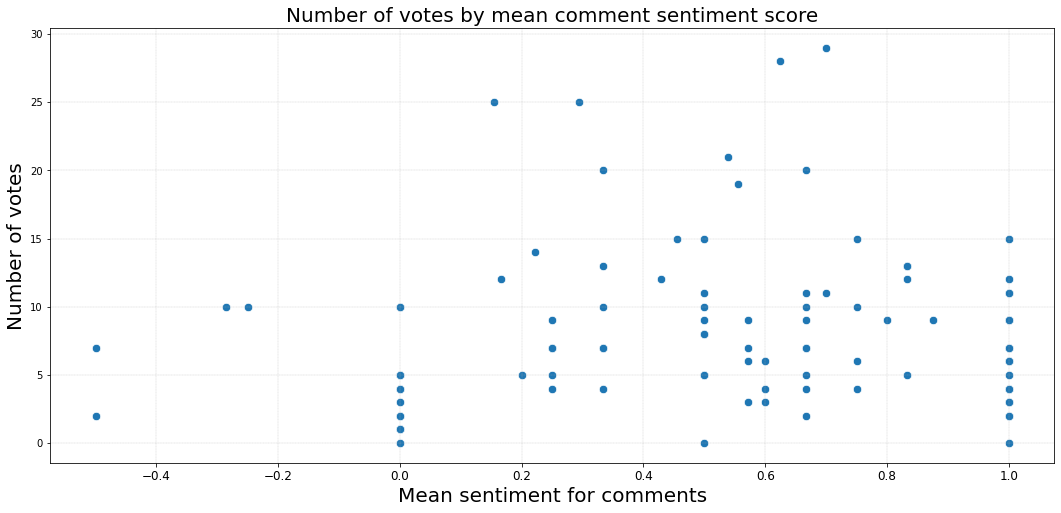

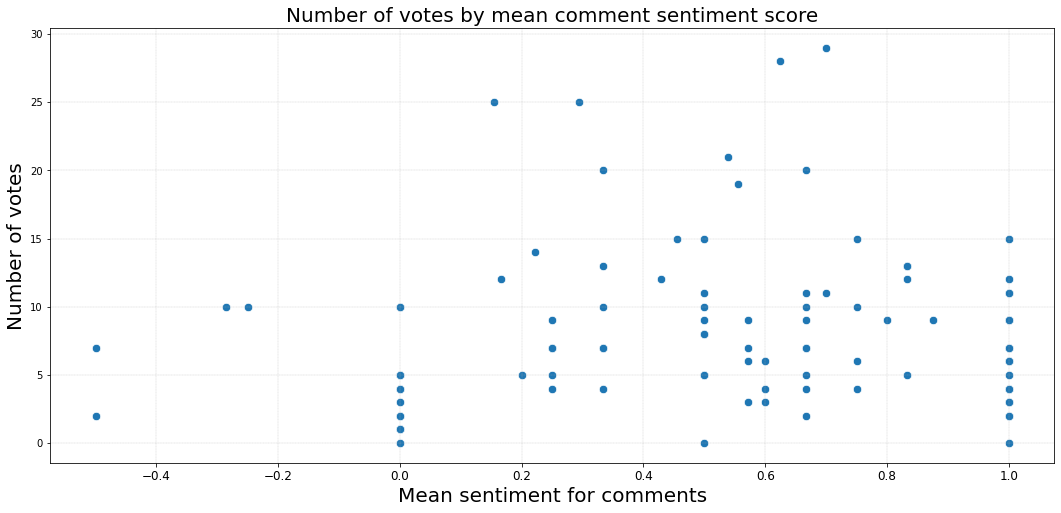

In [32]:
plot_votes_vs_x(df = ideas,
                x= "mean_comment_sentiment",
                x_label="Mean sentiment for comments",
                title="Number of votes by mean comment sentiment score");